In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh
import cmath

from matplotlib import cm

""" import the Tilings package... """
import sys
sys.path.insert(0, '../../gaps_topology/Tilings') # prepend the path to the Tiling package
import Tilings as tl
import Penrose_envs as envs
import SKK_approximants_Penrose as skk

%matplotlib inline

"""
Styling
See: http://matplotlib.org/users/customizing.html

TeX rendering:
You can use TeX to render all of your matplotlib text if the rc
parameter text.usetex is set.  This works currently on the agg and ps
backends, and requires that you have tex and the other dependencies
described at http://matplotlib.org/users/usetex.html
properly installed on your system.  The first time you run a script
you will see a lot of output from tex and associated tools.  The next
time, the run may be silent, as a lot of the information is cached in
~/.tex.cache
"""
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern'], 'size':14})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
# colors
BostonBlue = np.array([0., 104., 139.])/255
comp = np.array([200., 35., 0.])/255
# linewidth of plots
rc('lines', lw = 2)
# fontsize of the labels
rc('axes', labelsize = 16)

# SKK tiling class

In [3]:
class SKKPenrose(tl.Penrose):
    def __init__(self):
        """
        Init the tiling with an half skinny rhombus
        """
        e = envs.e
        orig = 0
        init_shapes = envs.loz(0, -e[1], -e[4])
        init_shapes = (init_shapes[0],)
        super().__init__(init_shapes)

        # the 2 points of the tiling which have the most similar local environment
        e = envs.e
        tau = (1.+np.sqrt(5))*0.5
        self._p1 = -e[1]/tau**2
        self._p2 = -e[4]
        if tl.ROUND:
            self._p1 = np.around(self._p1, tl.DEC)
            self._p2 = np.around(self._p2, tl.DEC)
        
    def inflate(self, ninfl):
        """
        Inflate the initial tiling,
        affect the miror symmetry order to the nodes,
        compute the heights
        and compute the Hamiltonians
        """
        # inflate the tiling
        self.it_sub(ninfl)
        # generate the SKK boundary conditions
        skk.affect_order(self, ninfl)
        # compute the height field
        self.integrate_arrow_field(0, arrow_field='double_arrow', copy = False)
        # compute the Hamiltonians
        self._Honsite, self._Hhop = skk.symmetric_hams(self._graph)
        
    def groundstate(self, V):
        """
        Compute the groundstate, add the info to the graph
        """
        # compute the groundstate in the symmetric representation
        En, gs = eigsh(self._Hhop + V*self._Honsite, k=1, which = "SA")
        # go to the realspace representation
        gs = np.abs(gs.flatten())
        gs = skk.torealspace(self._graph, gs)
        # add the groundstate data to the graph
        nx.set_node_attributes(self._graph, "gs", dict(zip(self._graph.nodes(), gs)))
        return gs
        
    def h12(self):
        """
        The height difference h(p2)-h(p1)
        """
        return (2*(self._ninf % 2) - 1)*2
    
    def beta(self):
        """
        Measure beta for the groundstate
        """
        if "gs" not in self._graph.node[0]:
            raise RuntimeError('Groundstate is not computed yet, try executing self.groundstate first.')
        return (self._graph.node[self._p2]["gs"]/self._graph.node[self._p1]["gs"])**(1./self.h12())
    
    def cake(self):
        """
        Add the cake part to the graph
        """
        if "gs" not in self._graph.node[0]:
            raise RuntimeError('Groundstate is not computed yet, try executing self.groundstate first.')
        # compute beta
        beta = self.beta()
        # remove the beta part from the gs to obtain the "cake"
        cake = {p:data["gs"]*beta**(-data["weight"]) for p, data in self._graph.nodes(data=True)}
        # add the cake data to the graph
        nx.set_node_attributes(self._graph, "cake", cake)

In [3]:
ninfl = 10
approx = SKKPenrose()
approx.inflate(ninfl)
planes = approx.planes()
lift = approx.lift()

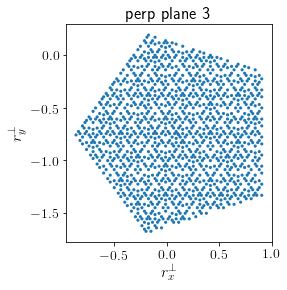

In [4]:
# index of the plane we want to plot
i = 3
# retrive position
x, y = np.transpose([np.dot(approx._perp, lift[p]) for p in planes[i]])
s = 10.
plt.scatter(x, y, s=s, edgecolor='', cmap="inferno", alpha=1.)

# axes labels
plt.xlabel(r"$r^\perp_x$")
plt.ylabel(r"$r^\perp_y$")
plt.title("perp plane " + str(i))
plt.axes().set_aspect('equal')

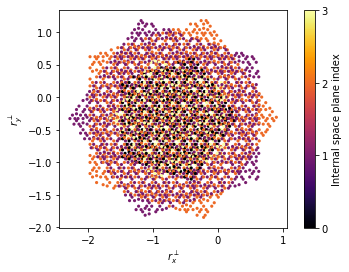

In [6]:
# color the nodes according to the type of data we want
node_color = [approx._graph.node[p]["perp_index"] for p in approx._graph]

s = 10.
# retrive position
x, y = np.transpose([np.dot(approx._perp, lift[p]) for p in approx._graph])
plt.scatter(x, y, s=s, c=node_color, edgecolor='', cmap="inferno", alpha=1.)

# set up the colorbar
cb = plt.colorbar(ticks=range(4))
# title of the colorbar
cb.ax.set_ylabel(r'Internal space plane index')
# custom ticks for the colorbar
#cb.ax.set_yticklabels(['Low', 'Medium'])
# axes labels
plt.xlabel(r"$r^\perp_x$")
plt.ylabel(r"$r^\perp_y$")
plt.axes().set_aspect('equal')

# Plots

In [5]:
"""
SKK approximant and graph
"""
ninfl = 12
approx = SKKPenrose()
approx.inflate(ninfl)

In [6]:
"""
Compute the groundtsate
"""
V = 10.
approx.groundstate(V)

print("length =", len(approx._graph), "lambda =", 1./approx.beta()**2.)
# compute the cake
cake = approx.cake()

length = 61191 lambda = 0.880963023432


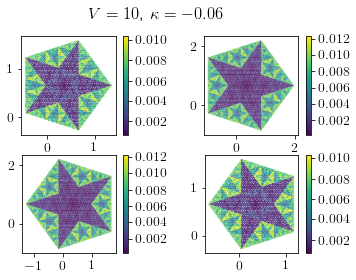

In [11]:
planes = approx.planes()
lift = approx.lift()

# which part of the wf to plot (exponential or cake)
term = 'cake'
# set the color reference
color = list(nx.get_node_attributes(approx._graph, term).values())
vmin = np.min(color)
vmax = np.max(color)

f, axarr = plt.subplots(2, 2)
# node size for the tiny-spaced planes
stiny = 0.4
for idx in range(4):
    x, y = np.transpose([np.dot(approx._perp, lift[p]) for p in planes[idx]])
    j = int((idx - idx % 2)/2 % 2)
    i = idx % 2
    # choose node size according to plane
    if idx == 0 or idx == 3:
        s = 2.4*stiny
    else:
        s = stiny
#     s = stiny
    # color the nodes according to the type of data we want
    node_color = [approx._graph.node[p][term] for p in planes[idx]]
    axarr[i, j].scatter(x, y, s=s, c=node_color, edgecolor='', cmap="viridis", alpha=1.)#, vmin=vmin, vmax=vmax)
    axarr[i, j].set_aspect('equal')
    # color bar
#     if j == 0:
    sm = plt.cm.ScalarMappable()
    sm.set_array(node_color)
    cb = f.colorbar(sm, ax = axarr[i, j])

# sm = plt.cm.ScalarMappable()
# sm.set_array(node_color)
# cb = f.colorbar(sm)
f.suptitle(r"$V = 10$" + r", $\kappa = -0.06$")
f.savefig("SKK_Penrose_" + term + "_V_" + str(V) + "_" + str(ninfl) + "_perp.png", dpi=400, alpha=1.)

In [49]:
"""
Plot the graph over a region
"""

def subgraph(graph, in_region):
    """
    Return the subgraph containing the nodes in a given region in physical space.
    """
    selected_nodes = [p for p in graph if in_region(skk.vec(p))]
    return nx.subgraph(graph, selected_nodes)

L = .07
r0 = np.array([0., -.3])
def in_region(r):
    """
    True is point r is in the region.
    """
    return r0[0] <= r[0] <= r0[0] + L and r0[1] <= r[1] <= r0[1] + L

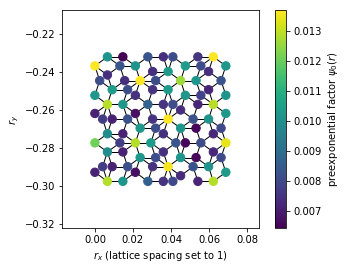

In [51]:
"""
Plot with networkx (suited for small graphs, because edges are visible)
"""
# select a small subgraph to plot (the previous cell has to be run first)
ugraph = subgraph(approx._graph, in_region)
# which part of the wf to plot (exponential or cake)
term = 'cake'
# retrive position
pos = {p:(p.real, p.imag) for p in ugraph}
# color the nodes according to the type of data we want
node_color = [ugraph.node[p][term] for p in ugraph]

s = 70.
nx.draw_networkx(ugraph, pos, with_labels=True, labels=nx.get_node_attributes(ugraph, 'type'),
                 font_color='w', node_size=s, width=1, node_color=node_color)

# set up the colorbar
sm = plt.cm.ScalarMappable()
sm.set_array(node_color)
cb = plt.colorbar(sm)#,  ticks=[0.1, 0.12])
# title of the colorbar
if term == 'cake':
    cb.ax.set_ylabel(r'preexponential factor $\psi_0(r)$')
else:
    cb.ax.set_ylabel(r'exponential factor $\exp(\kappa h(r))$')
# custom ticks for the colorbar
#cb.ax.set_yticklabels(['Low', 'Medium'])
# axes labels
plt.xlabel(r"$r_x$ (lattice spacing set to 1)")
plt.ylabel(r"$r_y$")
plt.axes().set_aspect('equal')
plt.savefig("SKK_Penrose_subgraph_" + term + "_" + str(ninfl) + "_para.pdf", alpha = 1., dpi=300)

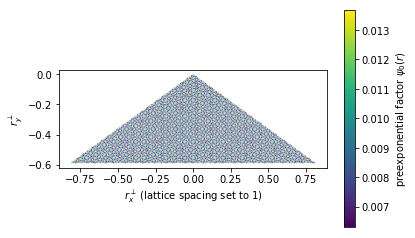

In [52]:
"""
Plot with plt.scatter (do not plot the edges, suited for large approximants)
"""

# which part of the wf to plot (exponential or cake)
term = 'cake'
# color the nodes according to the type of data we want
node_color = [approx._graph.node[p][term] for p in approx._graph]

s = 1.
# retrive position
x, y = np.transpose([(p.real, p.imag) for p in approx._graph])
plt.scatter(x, y, s=s, c=node_color, edgecolor='', cmap="viridis", alpha=1.)

# set up the colorbar
cb = plt.colorbar()#,  ticks=[0.1, 0.12])
# title of the colorbar
if term == 'cake':
    cb.ax.set_ylabel(r'preexponential factor $\psi_0(r)$')
else:
    cb.ax.set_ylabel(r'exponential factor $\exp(\kappa h(r))$')
# custom ticks for the colorbar
#cb.ax.set_yticklabels(['Low', 'Medium'])
# axes labels
plt.xlabel(r"$r^\perp_x$ (lattice spacing set to 1)")
plt.ylabel(r"$r^\perp_y$")
plt.axes().set_aspect('equal')
plt.savefig("SKK_Penrose_" + term + "_" + str(ninfl) + "_para.png", dpi=400, alpha=1.)

# Varying model

In [3]:
def betas(approx, Vrange):
    betas = []
    for V in Vrange:
        # compute the groundstate
        approx.groundstate(V)
        # measure beta
        betas.append(approx.beta())
        
    return betas

In [4]:
# number of inflations
ninfl = 12
# first approximant
a1 = SKKPenrose()
a1.inflate(ninfl)
# next approximant
a2 = SKKPenrose()
a2.inflate(ninfl+1)
# next next approximant
# a3 = SKKPenrose()
# a3.inflate(ninfl+2)

In [2]:
"""
Compute the values of beta for the two successive approximants
"""
# Vrange = list(np.arange(-0.5, 2., 0.1)) + list(np.arange(2., 10., 0.5))
# betalist = []
# for a in (a1, a2):
#     betalist.append(betas(a, Vrange))
    
"""
Loadin' data
"""
ninfl = 12
betalist = []
for idx in range(ninfl, ninfl+2):
    Vrange, betas = np.loadtxt("data/Cake Nico/Penrose/Vbeta_n_" + str(idx) + ".dat").T
    betalist.append(betas)

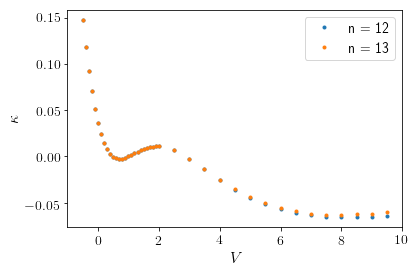

In [9]:
"""
Plottin' data
"""
for beta in betalist:
    kappa = -np.log(beta)
    plt.plot(Vrange, kappa, '.')
    plt.xlabel(r"$V$")
    plt.ylabel(r"$\kappa$")
legend = list(map(lambda n: "n = " + str(n), range(ninfl, ninfl+len(betalist))))
plt.legend(legend)
plt.savefig("kappa_Penrose_n_" + str(ninfl) + ".svg", dpi=400)

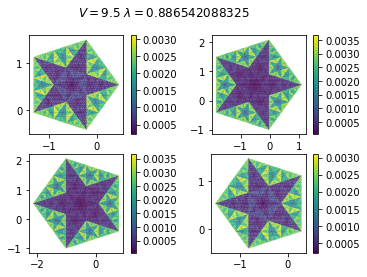

In [41]:
approx = a2
planes = approx.planes()
lift = approx.lift()
cake = approx.cake()

# which part of the wf to plot (exponential or cake)
term = 'cake'
# set the color reference
color = list(nx.get_node_attributes(approx._graph, term).values())
vmin = np.min(color)
vmax = np.max(color)

f, axarr = plt.subplots(2, 2)
# node size for the tiny-spaced planes
stiny = 0.2
for idx in range(4):
    x, y = np.transpose([np.dot(approx._perp, lift[p]) for p in planes[idx]])
    j = int((idx - idx % 2)/2 % 2)
    i = idx % 2
    # choose node size according to plane
    if idx == 0 or idx == 3:
        s = 2.4*stiny
    else:
        s = stiny
#     s = stiny
    # color the nodes according to the type of data we want
    node_color = [approx._graph.node[p][term] for p in planes[idx]]
    axarr[i, j].scatter(x, y, s=s, c=node_color, edgecolor='', cmap="viridis", alpha=1.)#, vmin=vmin, vmax=vmax)
    axarr[i, j].set_aspect('equal')
    # color bar
#     if j == 0:
    sm = plt.cm.ScalarMappable()
    sm.set_array(node_color)
    cb = f.colorbar(sm, ax = axarr[i, j])

# sm = plt.cm.ScalarMappable()
# sm.set_array(node_color)
# cb = f.colorbar(sm)
f.suptitle(r"$V = $" + str(Vrange[-1]) + r" $\lambda = $" + str(1./approx.beta()**2.))
f.savefig("SKK_Penrose_" + term + "_V_" + str(V) + "_" + str(approx._ninf) + "_perp.png", dpi=400, alpha=1.)

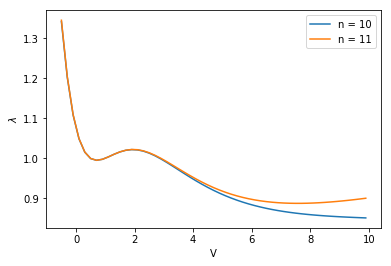

In [61]:
lambdas0 = 1./np.array(betalist[0])**2.
lambdas1 =1./np.array(betalist[1])**2.

plt.plot(Vrange, lambdas0, '-')
plt.plot(Vrange, lambdas1, '-')
plt.xlabel("V")
plt.ylabel(r"$\lambda$")
plt.legend(("n = " + str(ninfl), "n = " + str(ninfl+1)))
plt.savefig("lambda_Penrose_n_" + str(ninfl) + ".pdf", dpi=400)

# Multifractal

In [99]:
def a(z):
    return 1.+5.*z+z**2

def da(z):
    return 5.+2.*z

def om(z):
    aa = a(z)
    return 0.5*(aa + np.sqrt(aa**2-4*z**2.))

def dlogom(z):
    """
    z times the logarithmic derivative of omega
    """
    denom = np.sqrt((1. + z*(3. + z))*(1. + z*(7. + z)))
    return z*(5.+2.*z + (5. + z*(23. + z*(15. + 2.*z)))/denom)/(1.+5.*z+z**2 + denom)

# the normalization in the theoretical expression of the exponent
norm = np.log(om(1.))
# vectorization
vom = np.vectorize(om)
vdlogom = np.vectorize(dlogom)

def tau_theo(q, betasq):
    """
    The function to fit
    """
    return np.log(vom(betasq)**q/vom(betasq**q))/norm
    
def d_theo(q, betasq):
    return np.log(vom(betasq)**q/vom(betasq**q))/((q-1.)*norm)

def alpha_theo(q, betasq):
    return (np.log(vom(betasq)) - np.log(betasq)*vdlogom(betasq**q))/norm

def f_theo(q, betasq):
    betasqq = betasq**q
    return (np.log(vom(betasqq)) - np.log(betasqq)*vdlogom(betasqq))/norm

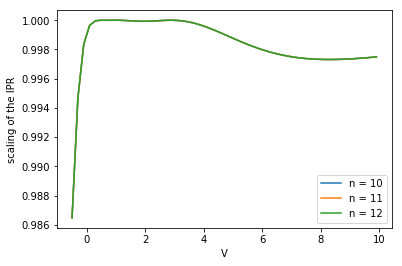

In [107]:
"""
Plot the scaling of the IPR
"""

iprs = []
for beta in betalist:
    ipr = d_theo(2., betas**2.)
    iprs.append(ipr)

for ipr in iprs:
    plt.plot(Vrange, ipr, '-', alpha = 1.)
    plt.xlabel("V")
    plt.ylabel(r"scaling of the IPR")
legend = list(map(lambda n: "n = " + str(n), range(ninfl, ninfl+len(betalist))))
plt.legend(legend)
plt.savefig("IPR_Penrose_n_" + str(ninfl) + ".pdf", dpi=400)

# Test area

In [3]:
# is the non-trivial extended state at V = 3?
for betas in betalist:
    betad = {np.around(V,2):beta for V, beta in zip(Vrange, betas)}
    print(betad[2.9])

NameError: name 'betalist' is not defined

In [8]:
"""
SKK approximant and graph
"""
ninfl = 10
approx = SKKPenrose()
approx.inflate(ninfl)

"""
Compute the groundtsate
"""
V = 0.
approx.groundstate(V)

print("length =", len(approx._graph), "lambda =", 1./approx.beta()**2.)
# compute the cake
cake = approx.cake()

length = 9045 lambda = 1.0744962477


In [9]:
"""
Export graph for Rémy
"""
f = open("coordination_" + str(ninfl) + ".dat", 'w')
for p, data in approx._graph.nodes(data = True):
    neighs = approx._graph[p]
    neighs = [list(skk.vec(n)) for n in neighs]
    p = list(skk.vec(p))
    line = np.array([p] + neighs).flatten()
    line = [str(pos) for pos in line]
    line = " ".join(line) + "\n"
    f.write(line)    
f.close()

In [53]:
"""
Coordinates of the 3 apexes of the triangle
"""
[[p.real, p.imag] for p in approx._init_shapes[0][1]]

[[0, 0],
 [-0.80901699437494745, -0.58778525229247314],
 [0.80901699437494734, -0.58778525229247325]]

# Lift

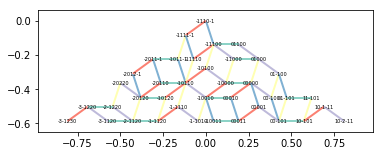

In [10]:
"""
Test that Penrose is correctly lifted to 5D
"""
ninfl = 4
approx = SKKPenrose()
approx.inflate(ninfl)
lift = approx.lift()

ei = lambda i: (-1)**((i) // 5)*approx._basis[(i)%5]
color = {tuple(ei(i)):plt.cm.Set3(i/10) for i in range(5)}
edge_color = [color[tuple(np.abs(approx.__get_5D_vec__(e[0], e[1])))] for e in approx._graph.edges()]

def to_string(vec):
    """
    convert a vector (of integer elements) to a string
    """
    s = ''
    for el in vec:
        s += str(int(el))
    return s

pos = {p:(p.real, p.imag) for p in approx._graph}
labels = {p:to_string(lift[p]) for p in approx._graph}
s = 0.
nx.draw_networkx(approx._graph, pos, with_labels=True, labels=labels,
                 node_size=s, width=2, edge_color = edge_color, font_size=5)
plt.axes().set_aspect('equal')
plt.savefig("Penrose_lift.pdf", alpha = 1.)

# Varying approximant size

In [ ]:
# number of inflations
nstart = 13
nstop = 15
# value of V
V = 2.
a = SKKPenrose()
bets = []
for n in range(nstart, nstop):
    a.inflate(n)
    # compute the groundstate
    a.groundstate(V)
    print(len(a._graph))
    # measure beta
    bets.append(a.beta())
lambdas = 1./np.asarray(bets)**2.
kappas = -np.log(bets)

In [ ]:
lambdas

In [19]:
lbp = [1.20521878491068,
0.92269656399268,
1.12716797696325,
1.05358366136032,
1.08431969726415,
1.07161692503250,
1.07645465984201,
1.07449624769043,
1.07521692440751,
1.07492814309309,
1.07503362860260]

# Fractal dimensions

In [3]:
# number of inflations
nstart = 3
nstop = 14
# value of V
V = -0.5
a = SKKPenrose()
"""
Savin'
"""
# for n in range(nstart, nstop):
#     a.inflate(n)
#     # compute the groundstate
#     gs = a.groundstate(V)
#     np.save("data/groundstate_Penrose_changing_V/V_" + str(V) + "_gen_"+str(n), gs)
#     print("computed groundstate, n = ", str(n))

"""
Loadin'
"""
gss = []
for n in range(nstart, nstop):
    # load the groundstate
    gs = np.load("data/groundstate_Penrose_changing_V/V_" + str(V) + "_gen_"+str(n) + ".npy")
    gss.append(gs)

In [5]:
len(gss[-2])

61191